## DEFINITIVE EXPLORATORY DATA ANALYSIS 

In this notebook I will carry out further EDA scripts in order to extract more meaningful information from the cleaned version of the original dataset. 
I've created two differently cleaned datasets: one using median and frequency as the imputation strategy, and one using KNN for the imputation of missing values. Further studies on the matter revealed that using this last imputation strategy might prove to be the winning solution in this specific medical diagnosis context. Therefore, in this EDA I will carry out further analyses on the KNN-imputed dataset. Just in case, I reserve to compare this version with the median-imputed one at a modeling stage. 

In [1]:
file_path = r'C:\unibo-dtm-ml-2526-cervical-cancer-predictor\data\processed_data\cleaned_data_knn_imputation.csv'
with open(file_path, 'r') as f:
    lines = f.readlines()
print('Read {} lines'.format(len(lines)))

Read 813 lines


Importing the necessary libraries. 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


Outlining the renewed profile of the dataset. 

In [3]:
# repeat the data profiling pipeline for the newly cleaned data
df = pd.read_csv(file_path)

print("\nDataset Info: \n")
print(df.info())

#check whether everything went smoothly at the data cleaning stage
print("\nMissing Values: \n")
print(df.isnull().sum()) 

print("\nDuplicate Values: \n")
print(df.duplicated().sum())

print("\nDescriptive Statistics:")
print(df.describe(include='all'))



Dataset Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812 entries, 0 to 811
Data columns (total 34 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 812 non-null    int64  
 1   Number of sexual partners           812 non-null    int64  
 2   First sexual intercourse            812 non-null    int64  
 3   Num of pregnancies                  812 non-null    int64  
 4   Smokes                              812 non-null    int64  
 5   Smokes (years)                      812 non-null    float64
 6   Smokes (packs/year)                 812 non-null    float64
 7   Hormonal Contraceptives             812 non-null    int64  
 8   Hormonal Contraceptives (years)     812 non-null    float64
 9   IUD                                 812 non-null    int64  
 10  IUD (years)                         812 non-null    float64
 11  STDs                        

### IDENTIFY CORRELATIONS 
Now that I have a refined version of the raw dataset, it is the right time to perform visualization and understanding of correlations. 

Text(0.5, 1.0, 'Feature Correlation Heatmap')

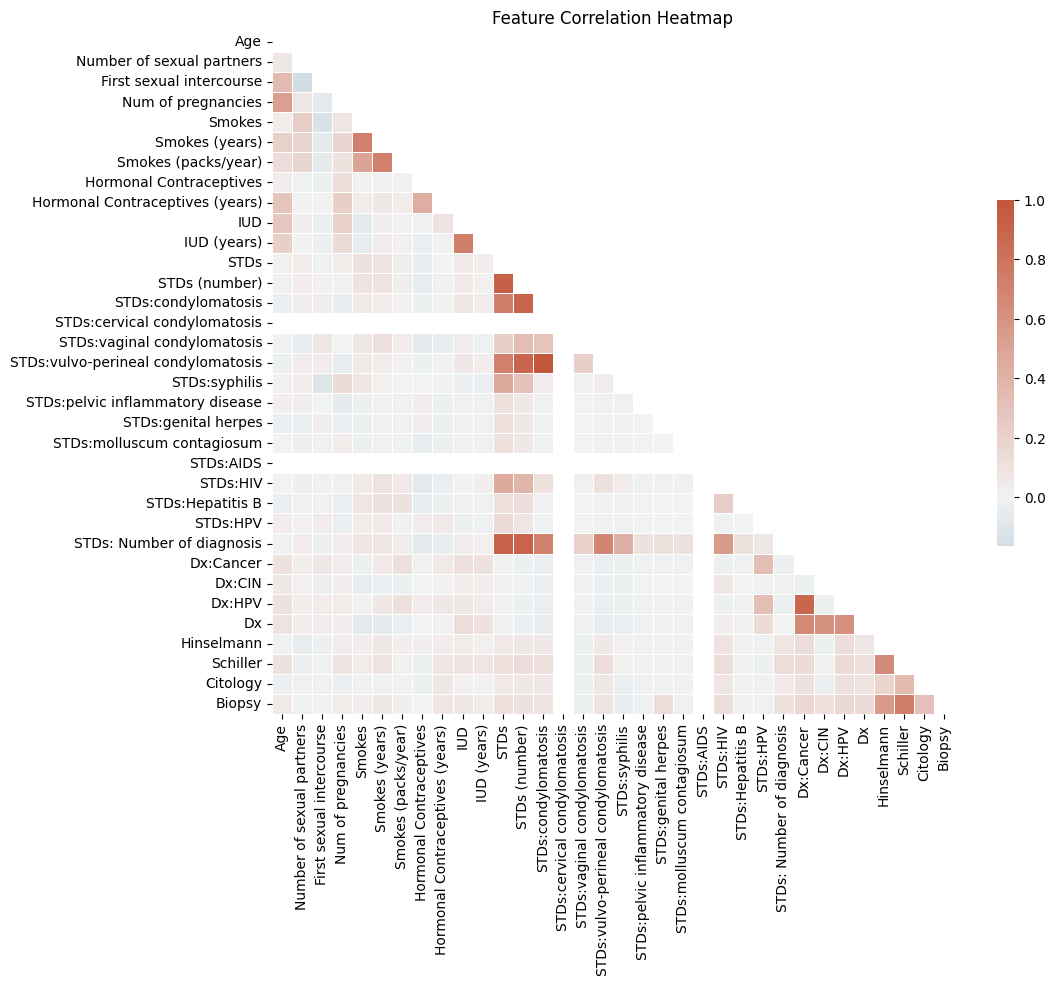

In [4]:
#Compute the correlation matrix
corr = df.select_dtypes(include=['number']).corr()

#generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr,dtype=bool))

#set up the matplotlib figure
f,ax = plt.subplots(figsize=(11,9))

#generate a custom diverging colormap
cmap = sns.diverging_palette(230,20,as_cmap=True)

#draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})


plt.title("Feature Correlation Heatmap")

In addition to the matrix, a list including the positively strongly correlated features (below 1.0) will now be shown, so as to make things clearer. 

In [5]:
#generating unique correlated pairs by using the mask earlier defined 
#and unstacking the couples
unique_pairs = corr.where(mask).unstack().dropna()

#sort them and remove self-correlations (where corr = 1.0)
sorted_pairs = unique_pairs.sort_values(kind="quicksort", ascending=False)
strong_pairs = sorted_pairs[sorted_pairs < 1.0]

#print the top 10 culprits
print("Top 10 Highest Correlations (Redundant Features):")
print(strong_pairs.head(10))


Top 10 Highest Correlations (Redundant Features):
STDs:vulvo-perineal condylomatosis  STDs:condylomatosis    0.987928
STDs (number)                       STDs                   0.919216
STDs: Number of diagnosis           STDs                   0.907344
STDs:condylomatosis                 STDs (number)          0.899952
STDs: Number of diagnosis           STDs (number)          0.897957
STDs:vulvo-perineal condylomatosis  STDs (number)          0.891160
Dx:HPV                              Dx:Cancer              0.886370
IUD (years)                         IUD                    0.737287
STDs:condylomatosis                 STDs                   0.729095
Biopsy                              Schiller               0.728266
dtype: float64


The same can be done with the most negatively correlated features: 

In [6]:
print("Top 5 Negative Correlations:")
print(strong_pairs.tail(5))

Top 5 Negative Correlations:
Dx                        Smokes                      -0.073737
Num of pregnancies        First sexual intercourse    -0.076384
STDs:syphilis             First sexual intercourse    -0.099779
Smokes                    First sexual intercourse    -0.134005
First sexual intercourse  Number of sexual partners   -0.164276
dtype: float64


What is it possible to extract from these results?
- Some features are enormously correlated, hence they're redundant. What will be done at a later stage will likely be removing one of the two features among the various couples of highly-correlated features. In particular, such couples are (with corr > 0.80)
    - STDs:condylomatosis - STDs:vulvo-perineal condylomatosis 
    - STDs - STDs (number)
    - STDs - STDs: Number of diagnosis
    - STDs:condylomatosis - STDs (number)
    - STDs (number) - Number of diagnosis 
    - STDs:vulvo-perineal condylomatosis - STDs (number)
    - Dx:HPV - Dx:Cancer

    Reasons behind these correlations mainly revolve around the medical domain, others depend on deterministic relationships (Binary vs. Count), and, when it comes to STDs: condylomatosis, the problem is that of the dominant class effect. 
- Negative correlation is very poor, as can be seen from the 5 most negatively correlated features. These couples' statistical irrelevance underlines one important thing about this dataset: since it is a risk factors dataset, risk factors are "additive" per se, meaning that there's no feature in this dataset such that its presence increases the cancer risk. 
- Interesting discovery: one correlation couple arises in particular among the 10 shown above, because it involves two features referred to two of the four diagnostic tests. In fact, Biopsy and Schiller tests are highly correlated, and that's because, in the medical diagnosys routine, these two tests are together part of a sequential diagnostic workflow that sees th Biopsy test being executed right after the Schiller one. This correlation among two of the four target variables is of vital importance: at a modeling stage, the model will likely be trained so decide how to handle biopsy based on how it handled Schiller. 

### FOCUS ON THE TARGET: THE FOUR DIAGNOSTIC TESTS

#### CLASS IMBALANCE VISUALIZATION
The goal of the project is to predict the four outcomes of the diagnostic tests. In this sense it is useful to first visualize how is the positive/negative ratio of the dataset for each test. 

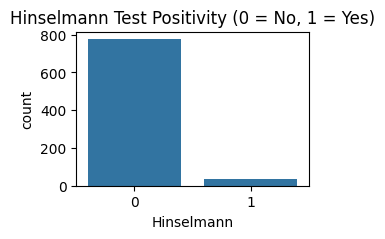

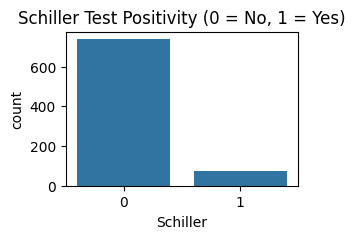

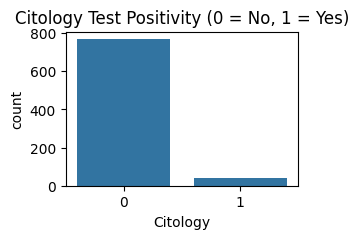

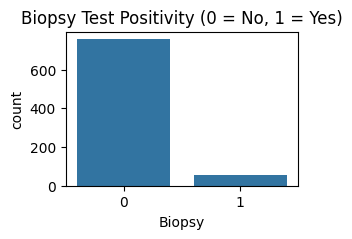

In [7]:
tests = ['Hinselmann', 'Schiller', 'Citology', 'Biopsy']
for target in tests: 
    plt.figure(figsize=(3,2))
    ax = sns.countplot(data=df, x=target)
    plt.title(f"{target} Test Positivity (0 = No, 1 = Yes)")

plt.show()

The four countplots shown above make it clear: there's a huge class imbalance towards negativity in the tests' results. This is a natural consequence when there's to deal with diagnostic medical datasets. 

#### MULTI-LABEL TARGET ANALYSIS
The reason why the goal of the project is to perform a multi-label classification task is that a patient can simultaneously be tested positive for multiple tests. Therefore, at this stage I want to understand how the four targets overlap (e.g., ask myself how likely a patient is tested positive for a test, when that patient has already been tested positive for another test).

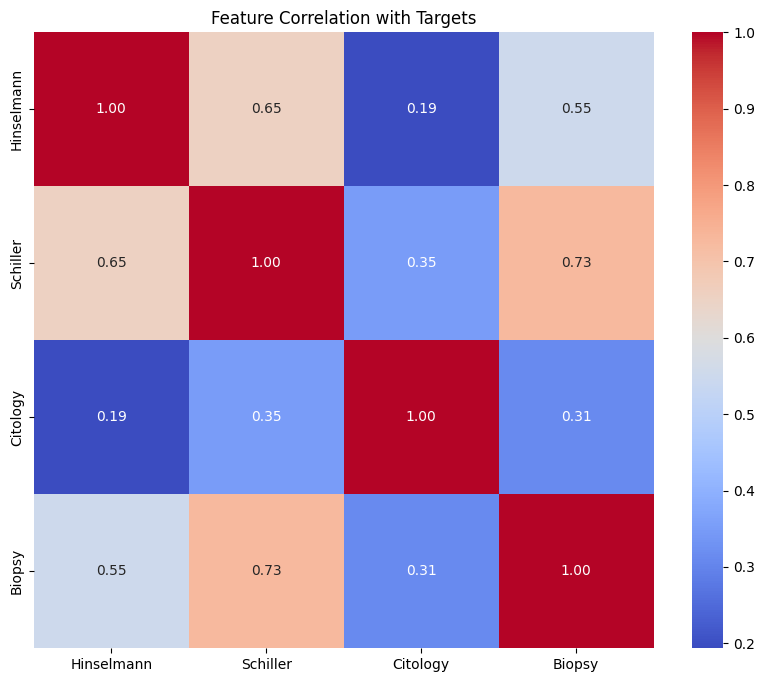

In [8]:
# Focus only on correlations with the targets
targets = ['Hinselmann', 'Schiller', 'Citology', 'Biopsy']
other_cols = [col for col in corr.columns if col not in targets]
plt.figure(figsize=(10, 8))
sns.heatmap(corr[targets].drop(other_cols),annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation with Targets")
plt.show()

The heatmap says it clearly: Biopsy and Schiller are two notably correlated tests. In 73% of the cases, if one patient is tested positive at the Schiller's test, he/she will be tested positive at the biopsy test. Climbing down the correlation ladder, Schiller and Hinselmann are one more discretely correlated couple (0.65), and the same, even if with lower correlation values (0.55) can be said for the Biopsy-Hinselmann couple. 
Some sort of a pattern can be understood from this heatmap: 
- Schiller and Biopsy is the most strongly correlated couple; 
- Hinselmann moderately relates with the two aforementioned tests; 
- Citology is the only test that is "set apart": it is weakly correlated with all the three other tests. 

#### BIVARIATE ANALYSIS 


Investigating how individual features correlate with the four targets. 
The choice for the most relevant features at this stage has fallen on "Age", "Smokes (years)", and "Hormonal contraceptives (years)". 


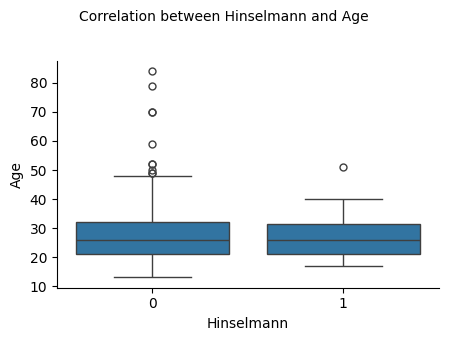

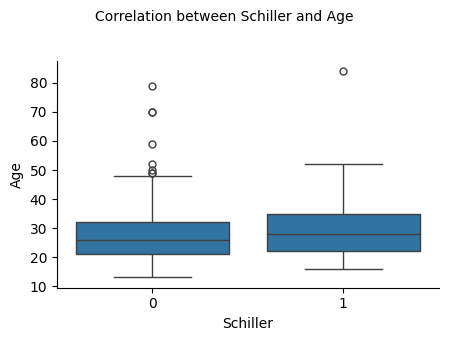

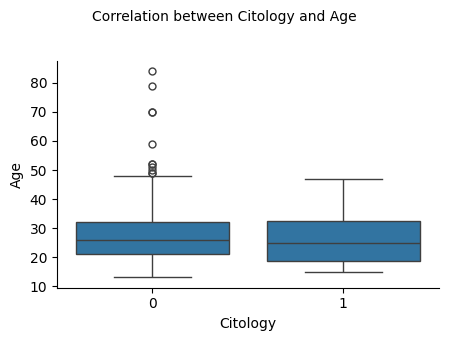

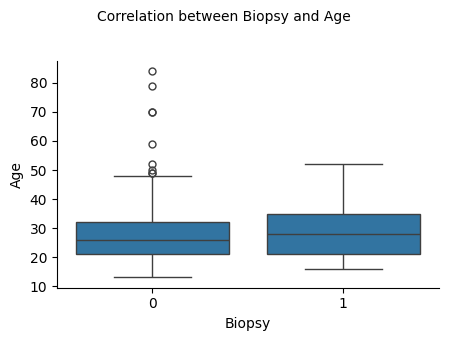

In [9]:
#Age relationship discovery with the four target variables
for targ in targets: 
    Plot = sns.catplot(x=targ, y="Age", kind="box", 
                    data=df, height=3, aspect=1.5)
    Plot.fig.suptitle(f'Correlation between {targ} and Age', size=10, y=1.12)
    plt.show()


C:\Users\pippo\AppData\Local\Temp\ipykernel_34952\4235463867.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=targ, y="Smokes (years)", data=df,


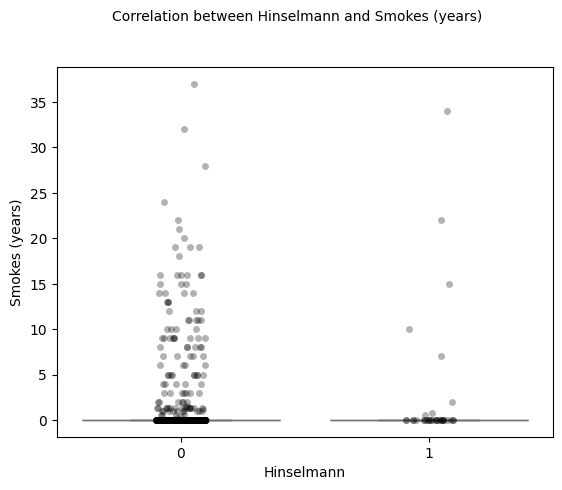

C:\Users\pippo\AppData\Local\Temp\ipykernel_34952\4235463867.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=targ, y="Smokes (years)", data=df,


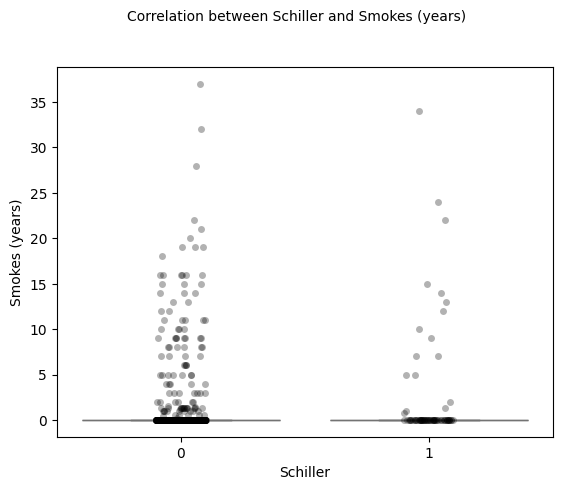

C:\Users\pippo\AppData\Local\Temp\ipykernel_34952\4235463867.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=targ, y="Smokes (years)", data=df,


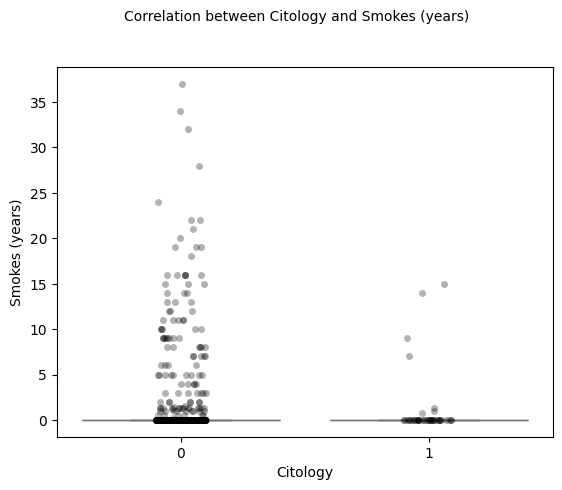

C:\Users\pippo\AppData\Local\Temp\ipykernel_34952\4235463867.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=targ, y="Smokes (years)", data=df,


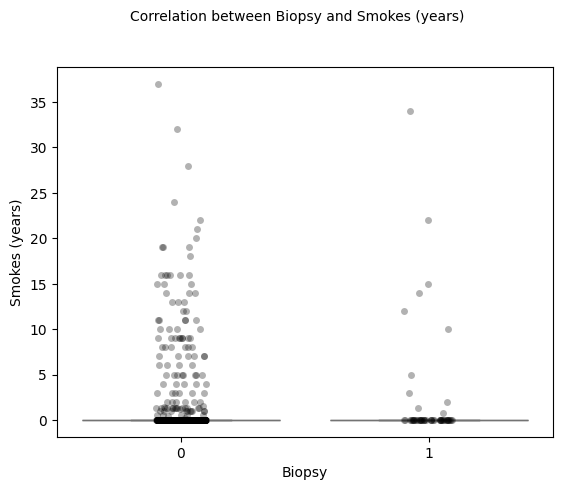

In [31]:
#Smokes (years) relationship discovery with the four target variables

#since this feature is a sparse one (most people don't smoke),
#instead of just uning a boxplot, I will also overlay a stripplot to show the distribution of individual points
for i, targ in enumerate(targets):
    sns.boxplot(x=targ, y="Smokes (years)", data=df, 
                palette="pastel", showfliers=False) 
    
    #setting alpha=0.3 helps see density where points overlap
    sns.stripplot(x=targ, y="Smokes (years)", data=df,
                  color='black', alpha=0.3, jitter=True)
    plt.suptitle(f'Correlation between {targ} and Smokes (years)', size=10, y=1)
    plt.show()

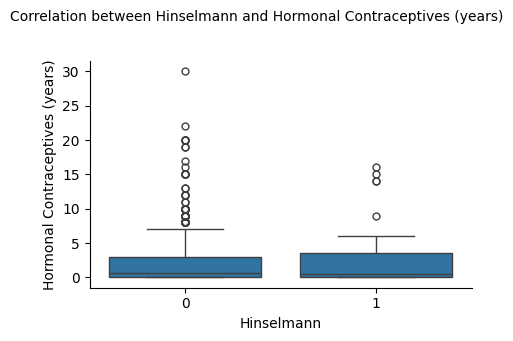

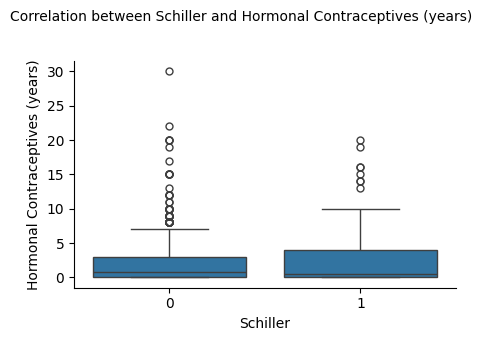

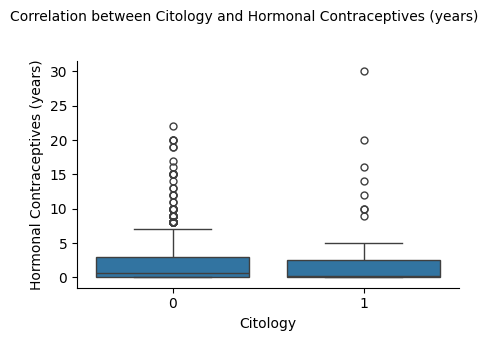

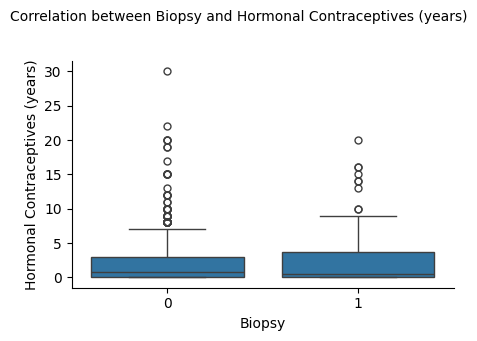

In [ ]:
#Hormonal contraceptives (years) relationship discovery with the four target variables
#boxplots will likely be smashed towards 0 because, contrarily to smoking,
#many more people use hormonal contraceptives, but the duration of usage is still heavily skewed towards shoert-term use
#boxplots are sufficient in this case because outliers and the boxplots features are more visible
for targ in targets: 
    Plot = sns.catplot(x=targ, y="Hormonal Contraceptives (years)", kind="box", 
                    data=df, height=3, aspect=1.5)
    Plot.fig.suptitle(f'Correlation between {targ} and Hormonal Contraceptives (years)', size=10, y=1.12)
    plt.show()


#### OUTLIER INVESTIGATION

#### CHECKING FOR NEAR-ZERO VARIANCE 